# Comparative Analysis of Structured vs Baseline LDA

This notebook loads `processed_data.csv` and performs topic modeling on two text inputs:
- **Structured approach:** Using the LLM-based structured text (column `structured_text`)
- **Baseline approach:** Using the preprocessed raw text (column `processed_text`)

We will train LDA models for each approach and evaluate them using:
- **Topic Coherence:** via Gensim’s CoherenceModel (e.g. using the `c_v` metric)
- **Topic Diversity:** computed as the ratio of unique words in top topics vs. total words
- **Perplexity:** based on the LDA model’s log perplexity on the corpus

We then generate interactive pyLDAvis visualizations, topic word clouds, analyze document–topic distributions,
and compare the metrics across both approaches.


## 1. Setup and Data Loading


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models
from gensim.models import CoherenceModel
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Download stopwords if needed
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# Load the processed data
df = pd.read_csv("results/processed_data.csv")
print("Data shape:", df.shape)
# Take a look at the first few rows
df.head()



Data shape: (50, 11)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sammucyo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,themes,emotional_tone,concerns,cognitive_patterns,social_context,original_text,id,structured_text,structured_tokens,processed_text,baseline_tokens
0,"['friendship dynamics', 'personal insecurities...",negative,"['fear of losing friends', 'feelings of annoya...","['catastrophizing feelings about friendships',...",['conflict with friends over physical contact'...,none of my friends probably like me i feel lik...,2471,"THEMES: friendship dynamics, personal insecuri...","['THEMES', 'friendship', 'dynamic', 'personal'...",none of my friends probably like me i feel lik...,"['none', 'friend', 'probably', 'annoy', 'despe..."
1,"['mental health awareness', 'entertainment', '...",neutral,"['boredom', 'seeking engagement']","['seeking distraction', 'curiosity about menta...","['social media recommendations', 'community di...",Any interesting shows on mh to watch ? So bored,10657,"THEMES: mental health awareness, entertainment...","['THEMES', 'mental', 'health', 'awareness', 'e...",any interesting shows on mh to watch so bored,"['interesting', 'show', 'watch', 'bored']"
2,"['imagination', 'quarantine', 'celebrity admir...",mixed,"['social isolation', 'mental health during qua...","['daydreaming', 'self-talk']","['isolation from friends and family', 'online ...",Is this okay? Normally(when we weren't confine...,12557,"THEMES: imagination, quarantine, celebrity adm...","['THEMES', 'imagination', 'quarantine', 'celeb...",is this okay normallywhen we werent confined t...,"['okay', 'normallywhen', 'confine', 'house', '..."
3,"['emotional expression', 'sensitivity', 'chang...",mixed,"['loss of ability to cry', 'frustration with e...","['self-doubt', 'catastrophizing']","['relationship with mother', 'memories of fath...",Why can’t I cry anymore? Alright I know this s...,11497,"THEMES: emotional expression, sensitivity, cha...","['THEMES', 'emotional', 'expression', 'sensiti...",why cant i cry anymore alright i know this sou...,"['cry', 'anymore', 'alright', 'sound', 'dumb',..."
4,"['motivation', 'feelings of heaviness', 'self-...",negative,"['lack of motivation', 'feeling overwhelmed', ...","['all-or-nothing thinking', 'catastrophizing',...","['relationship with husband', 'work environmen...","I never want to do anything Howdy, I'll try to...",5034,"THEMES: motivation, feelings of heaviness, sel...","['THEMES', 'motivation', 'heaviness', 'self', ...",i never want to do anything howdy ill try to m...,"['never', 'want', 'anything', 'howdy', 'ill', ..."


## 2. Preprocessing and Tokenization

We define a simple tokenizer function. Here, we remove punctuation, numbers, and stop words.
You may refine this preprocessing as required.

In [19]:
def clean_and_tokenize(text):
    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    # Remove short words and stopwords
    tokens = [word for word in tokens if len(word) > 2 and word not in STOPWORDS]
    return tokens

# Create new columns with tokenized data for each approach
# For structured LDA, we use the 'structured_text'
df['structured_tokens'] = df['structured_text'].apply(lambda x: clean_and_tokenize(x))
# For baseline LDA, we use the 'processed_text'
df['baseline_tokens'] = df['processed_text'].apply(lambda x: clean_and_tokenize(x))

# Preview tokens
print("Structured tokens sample:", df['structured_tokens'].iloc[0])
print("Baseline tokens sample:", df['baseline_tokens'].iloc[0])


Structured tokens sample: ['themes', 'friendship', 'dynamics', 'personal', 'insecurities', 'physical', 'boundaries', 'emotional', 'attachment', 'jealousy', 'emotion', 'negative', 'cognitive', 'catastrophizing', 'feelings', 'friendships', 'internalizing', 'belief', 'annoying', 'blackandwhite', 'thinking', 'regarding', 'relationships', 'concerns', 'fear', 'losing', 'friends', 'feelings', 'annoyance', 'perceived', 'emotional', 'abuse', 'jealousy', 'insecurity', 'keywords', 'conflict', 'friends', 'physical', 'contact', 'one', 'friend', 'feeling', 'uncomfortable', 'distance', 'previously', 'close', 'friend']
Baseline tokens sample: ['none', 'friends', 'probably', 'like', 'feel', 'like', 'annoying', 'desperate', 'get', 'attention', 'one', 'someone', 'one', 'used', 'crush', 'constantly', 'asked', 'physical', 'contact', 'sometimes', 'forgetting', 'ask', 'tell', 'stop', 'one', 'friends', 'told', 'feels', 'uncomfortable', 'trying', 'physical', 'contact', 'stop', 'ask', 'hesitantly', 'pat', 'head

## 3. Create Dictionary and Corpus for Each Approach

We build a Gensim dictionary and corpus for both the structured and baseline datasets.

In [20]:

# Structured approach
structured_tokens = df['structured_tokens'].tolist()
structured_dictionary = corpora.Dictionary(structured_tokens)
structured_corpus = [structured_dictionary.doc2bow(text) for text in structured_tokens]

# Baseline approach
baseline_tokens = df['baseline_tokens'].tolist()
baseline_dictionary = corpora.Dictionary(baseline_tokens)
baseline_corpus = [baseline_dictionary.doc2bow(text) for text in baseline_tokens]

print("Structured dictionary size:", len(structured_dictionary))
print("Baseline dictionary size:", len(baseline_dictionary))


Structured dictionary size: 628
Baseline dictionary size: 1583




## 4. Train LDA Models

We train two LDA models (using Gensim's LdaModel) on each corpus. Adjust the parameters as needed.



In [21]:
num_topics = 10  # set the number of topics (or use grid search / coherence-based selection)
passes = 20

# Train LDA on structured data
lda_structured = models.LdaModel(corpus=structured_corpus,
                                 id2word=structured_dictionary,
                                 num_topics=num_topics,
                                 passes=passes,
                                 random_state=42)

# Train LDA on baseline data
lda_baseline = models.LdaModel(corpus=baseline_corpus,
                               id2word=baseline_dictionary,
                               num_topics=num_topics,
                               passes=passes,
                               random_state=42)

print("Structured LDA topics:")
for idx, topic in lda_structured.print_topics(-1):
    print("Topic {}: {}".format(idx, topic))
    
print("\nBaseline LDA topics:")
for idx, topic in lda_baseline.print_topics(-1):
    print("Topic {}: {}".format(idx, topic))




Structured LDA topics:
Topic 0: 0.002*"medication" + 0.002*"themes" + 0.002*"health" + 0.002*"mental" + 0.002*"emotion" + 0.002*"bipolar" + 0.002*"keywords" + 0.002*"support" + 0.002*"concerns" + 0.002*"disorder"
Topic 1: 0.023*"cognitive" + 0.023*"negative" + 0.023*"themes" + 0.023*"keywords" + 0.023*"emotion" + 0.023*"concerns" + 0.023*"health" + 0.021*"social" + 0.019*"anxiety" + 0.017*"mental"
Topic 2: 0.025*"sleep" + 0.020*"themes" + 0.020*"cognitive" + 0.020*"keywords" + 0.020*"emotion" + 0.020*"online" + 0.020*"concerns" + 0.020*"threats" + 0.015*"social" + 0.015*"imagination"
Topic 3: 0.023*"negative" + 0.019*"feeling" + 0.019*"concerns" + 0.019*"cognitive" + 0.019*"emotion" + 0.019*"themes" + 0.019*"keywords" + 0.015*"lack" + 0.015*"relationships" + 0.015*"catastrophizing"
Topic 4: 0.028*"mental" + 0.024*"cognitive" + 0.021*"themes" + 0.021*"keywords" + 0.021*"concerns" + 0.021*"emotion" + 0.014*"feeling" + 0.014*"thinking" + 0.014*"political" + 0.014*"support"
Topic 5: 0.022*


## 5. Evaluation Metrics

We calculate the following:
- **Coherence:** using the c_v metric
- **Perplexity:** via the log_perplexity function
- **Topic Diversity:** computed as the ratio of unique top words from all topics

In [30]:
def compute_topic_diversity(lda_model, dictionary, topn=10):
    topics = lda_model.show_topics(num_topics=num_topics, num_words=topn, formatted=False)
    all_top_words = []
    for topic in topics:
        words = [word for word, _ in topic[1]]
        all_top_words.extend(words)
    diversity = len(set(all_top_words)) / (num_topics * topn)
    return diversity

# Calculate coherence for structured model
coherence_structured = CoherenceModel(model=lda_structured, texts=structured_tokens,
                                      dictionary=structured_dictionary, coherence='c_v').get_coherence()
# Calculate coherence for baseline model
coherence_baseline = CoherenceModel(model=lda_baseline, texts=baseline_tokens,
                                    dictionary=baseline_dictionary, coherence='c_v').get_coherence()

# Compute perplexity (lower is better)
perplexity_structured = np.exp2(-lda_structured.log_perplexity(structured_corpus))
perplexity_baseline = np.exp2(-lda_baseline.log_perplexity(baseline_corpus))

# Compute topic diversity
diversity_structured = compute_topic_diversity(lda_structured, structured_dictionary)
diversity_baseline = compute_topic_diversity(lda_baseline, baseline_dictionary)


In [31]:
metrics = {
    'Coherence (c_v)': [coherence_structured, coherence_baseline],
    'Perplexity': [perplexity_structured, perplexity_baseline],
    'Topic Diversity': [diversity_structured, diversity_baseline]
}
metrics_df = pd.DataFrame(metrics, index=['Structured', 'Baseline'])
print(metrics_df)


            Coherence (c_v)  Perplexity  Topic Diversity
Structured         0.364040   79.852687             0.38
Baseline           0.328441  165.719088             0.52


### Observations:

• **Coherence (c_v):**  
  The structured approach scores a higher coherence (0.364) compared to the baseline (0.328). This suggests that the topics generated using the structured text are more semantically related—i.e., the top words in each topic tend to co-occur in a meaningful way. For a neuroscience lab, this could mean that topics extracted through the LLM-based structured method are more likely to reflect well-defined mental health or neural constructs.

• **Perplexity:**  
  The structured model has a lower perplexity (approximately 79.85) versus the baseline model (around 165.72). Lower perplexity means the structured LDA model fits the data better and is better at predicting the distribution of words in the corpus. It indicates that the structured approach provides a more compact and reliable explanation of the data, which is beneficial when trying to relate these topics to underlying neural processes or clinical patterns.

• **Topic Diversity:**  
  The baseline approach shows higher topic diversity (0.52) compared to the structured approach (0.38). This metric reflects the ratio of unique words across the top words of all topics—so a higher diversity score means that the baseline topics cover a broader range of vocabulary. However, while the baseline may capture more variety, its lower coherence and higher perplexity suggest that the topics might be more diffuse or noisy. In contrast, the structured approach—although yielding less diverse topics—produces more focused, coherent themes that might better map onto specific neuroscience constructs.



## 6. Interactive pyLDAvis Visualizations

We generate interactive visualizations for both models using pyLDAvis.


In [24]:
# For Structured LDA
vis_structured = gensimvis.prepare(lda_structured, structured_corpus, structured_dictionary)
pyLDAvis.display(vis_structured) 




In [25]:
# For Baseline LDA
vis_baseline = gensimvis.prepare(lda_baseline, baseline_corpus, baseline_dictionary)
pyLDAvis.display(vis_baseline)

## 7. Topic Word Clouds

For each model, we generate word clouds for each topic.



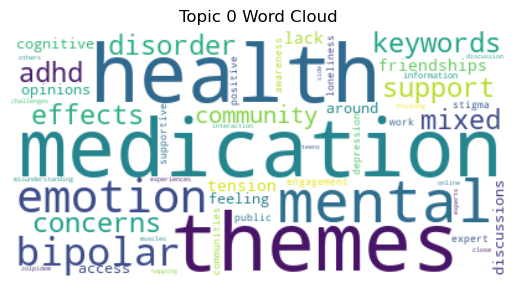

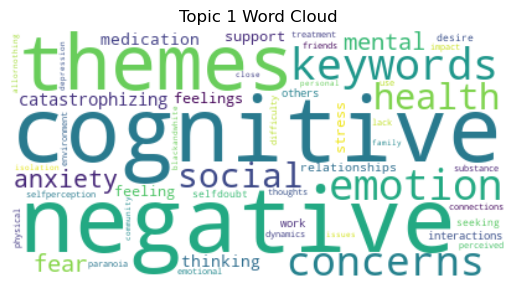

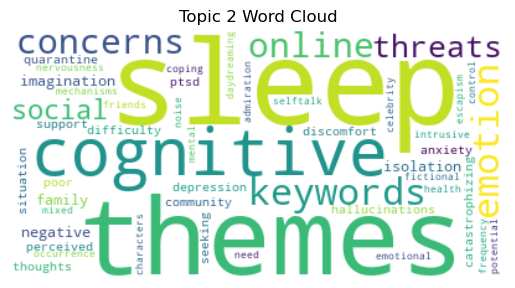

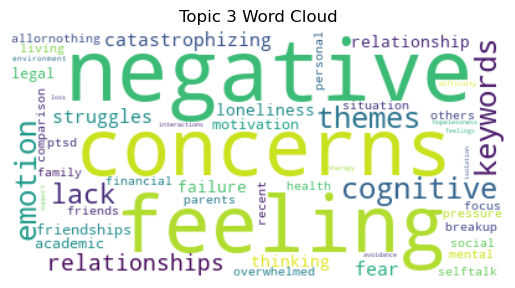

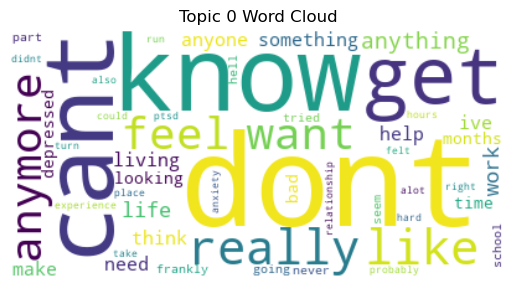

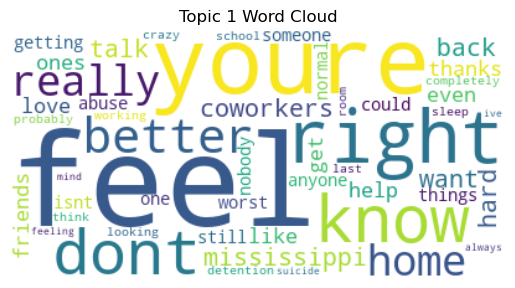

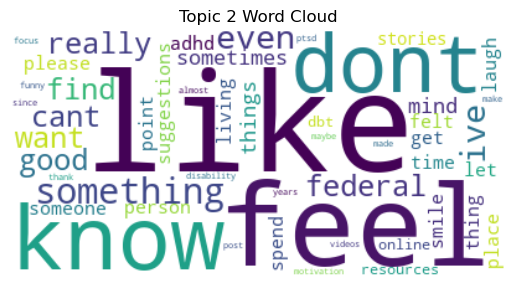

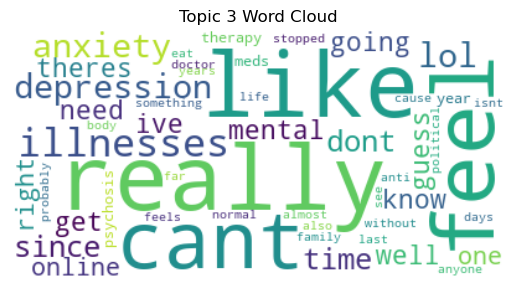

In [32]:
def plot_topic_wordcloud(lda_model, topic_num, dictionary, ax=None):
    # Get the topic as a dictionary {word: weight}
    topic = lda_model.show_topic(topic_num, topn=50)
    topic_words = dict(topic)
    wc = WordCloud(background_color='white', width=400, height=200)
    wordcloud_img = wc.generate_from_frequencies(topic_words)
    
    plt.figure()
    plt.imshow(wordcloud_img, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_num} Word Cloud")
    plt.show()
    
# Plot word clouds for first three topics of each model
for i in range(4):
    plot_topic_wordcloud(lda_structured, i, structured_dictionary)
    
for i in range(4):
    plot_topic_wordcloud(lda_baseline, i, baseline_dictionary)



### Observations

- Structured topics appear more “on target” for mental health research, using terms that directly reference mental health themes. This can make them easier to interpret clinically or align with neuroscience/psychology constructs.
- Baseline topics highlight the natural language that people actually use, which may expose more subtle personal expressions or slang but can be noisier or less obviously aligned to mental health frameworks.


From a quick look at these word clouds, we can see a difference in the types of words each approach is surfacing:

- Structured Approach (top pair of images)

      Words like “medication,” “themes,” “mental,” “health,” “concerns,” “negative,” “cognitive,” “emotion,” “anxiety,” etc.

- Baseline Approach (bottom pair of images)
     Words like “dont,” “feel,” “really,” “know,” “get,” “want,” “back,” “talk,” “better,” etc.

    These reflect more raw everyday language, typical of direct user expressions on a forum. Instead of higher-level mental health terms, you see colloquial phrases about personal experiences (“don’t feel,” “get anymore,” “know better,” etc.).

    This can capture the authentic style of how people talk about their day-to-day struggles but often lacks explicit mental health or clinical markers unless users specifically mention them.



## Representative Documents for Each Topic

For each topic in our LDA model, this cell prints a few representative documents with two pieces of information:
- The processed/structured text (used for LDA modeling)
- The original post text (for verification)

This will allow us to verify that the extracted topic represents the content of the original text.


In [34]:


def print_representative_documents_with_original(lda_model, corpus, processed_col, original_col, num_examples=3):
    """
    For each topic, prints num_examples documents with high topic probability.
    It shows both the processed text (e.g., structured_text) used for LDA and the original post (original_text)
    for verification.
    
    Parameters:
    - lda_model: trained LDA model.
    - corpus: the Gensim corpus used by the LDA model.
    - processed_col: column name in df with the processed text used for modeling.
    - original_col: column name in df with the original post.
    - num_examples: number of example documents per topic.
    """
    # Compute document-topic distributions for each document 
    doc_topic_dist = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=0)
        topics = sorted(topics, key=lambda x: x[0])
        doc_topic_dist.append([prob for _, prob in topics])
    doc_topic_dist = np.array(doc_topic_dist)
    
    num_topics = lda_model.num_topics
    
    for topic in range(num_topics):
        print("=" * 80)
        print(f"Topic {topic}")
        # Get document indices sorted in descending order by topic probability
        sorted_indices = np.argsort(doc_topic_dist[:, topic])[::-1]
        
        for i in range(num_examples):
            idx = sorted_indices[i]
            prob = doc_topic_dist[idx, topic]
            print("-" * 40)
            print(f"Document Index: {idx} (Contribution of Topic {topic}: {prob:.3f})")
            print("\n**Processed Text (used in modeling):**")
            print(df[processed_col].iloc[idx])
            print("\n**Original Post:**")
            print(df[original_col].iloc[idx])
            print("-" * 40, "\n")
        print("\n")


print_representative_documents_with_original(
    lda_model=lda_structured, 
    corpus=structured_corpus, 
    processed_col='structured_text', 
    original_col='original_text', 
    num_examples=3
)


Topic 0
----------------------------------------
Document Index: 1 (Contribution of Topic 0: 0.004)

**Processed Text (used in modeling):**
THEMES: mental health awareness, entertainment, self-discovery EMOTION: neutral COGNITIVE: seeking distraction, curiosity about mental health CONCERNS: boredom, seeking engagement KEYWORDS: social media recommendations, community discussions about shows

**Original Post:**
Any interesting shows on mh to watch ? So bored
---------------------------------------- 

----------------------------------------
Document Index: 48 (Contribution of Topic 0: 0.004)

**Processed Text (used in modeling):**
THEMES: sexual arousal, impulsivity, morals and reasoning, regret EMOTION: negative COGNITIVE: all-or-nothing thinking, impulsivity CONCERNS: loss of self-control, immorality during arousal, regret after actions KEYWORDS: seeking advice from others, desire for support

**Original Post:**
I struggle with Sexual Arousal A bit of an odd query indeed and I’m not e